# Book Recommender System Comparison

Tyler Kinkade    
University of Colorado

In this project, I compare six models used for a common unsupervised machine learning problem: reliably recommending items to users. The ability to quickly and effectively make recommendations to customers can increase profits in the online shopping industry and boost customer retention in the entertainment streaming industry by helping customers efficiently navigate the overwhelming number of options to locate the most relevant choices.

Recommender systems use item and user data to recommend items to users. There are a number of ways to accomplish this. Perhaps one of the simplest is to guess randomly. This could introduce users to new items, but it does not solve the problem of helping users quickly find items they are likely to be interested in. A slight improvement would be to randomly select samples from a normal (i.e., Gaussian) distribution of existing ratings. This would tend to recommend popular items with a few unusual ones mixed in, but it would also fail to consider users' individual preferences.

A more systemic approach would be to take into account the relative similarity of the characteristics of items (e.g., genre) and recommend those items which are most similar to items in which a user had previously expressed an interest (explicitly or implicitly). Such algorithms are called _content-based filtering,_ and are independent of other users (Leskovec et al., 2020). One downside to such an approach is that it requires adequate characterization of the items. Another is that it will not recommend items dissimilar to ones the user has previously liked, but which the user might have actually liked nonetheless. 

A different approach is _collaborative filtering,_ which considers a user's preferences relative to other users. A disadvantage of collaborative filtering is that it requires enough data on users' preferences so that comparisons can be made. It also tends to favor already popular items. This category can be further divided into memory-based and model-based approaches (Lemire & Machlachlan, 2005). Memory-based collaborative filtering weights predictions by the similarity between users or between the implicit or explicit ratings of items by users. However, such approaches are memory-intensive and require distributed computing in real-world implementations. Model-based collaborative filtering are generally faster to query.

One model-based collaborative filtering algorithm is a _baseline estimate model_ (Koren, 2010). The model incorporates the user's tendency to rate items higher or lower than average as well as an item's average rating relative to the average for all items. The model can be further improved by minimizing the regularized squared error (i.e., L2 or "ridge" regularization) of the baseline estimate.

A similar approach is a _slope one model_ (Lemire & Maclachlan, 2005). Unlike the baseline estimate model, slope one only includes the ratings of users who have rated some item in common with the target user and only items that the user has rated. Thus, it is more specific to the user and item while avoiding the memory problems associated with calculating pairwise similiarity measures on large rating data sets.

Another model-based collaborative filtering approach is using _matrix factorization_ to estimate the unrated items. This is sometimes called _latent factor-based filtering,_ which refers to the latent factors or dimensions derived when factoring the rating matrix. _Singular value decomposition_ (SVD) and _non-negative matrix factorization_ (NMF) are commonly used (Koren et al., 2009; Zhang et al., 2006). A disadvantage of this approach is that it cannot easily incorporate new items. Neural networks can also be used for collaborative filtering. These systems can incorporate new items but can be difficult to scale.

For this project, I will use k-fold cross-validation to compare the effectiveness of normal predictor, content-based, baseline estimate, slope one, SVD, and NMF recommender models with real-world book ratings data. Memory-based collaborative filtering is not included due to system memory limitations and neural networks models are not included due to space and time constraints.

I begin by describing the data. This is followed by preparing the data and performing exploratory analysis. Next, I build and train the models. Then, I analyze the models and discuss the results before concluding.

# Data

## Source

The data was originally collected from the [BookCrossing website](https://www.bookcrossing.com) by University of Freiburg Professor Cai-Nicolas Ziegler and is freely available for research use from his [lab's website](http://www2.informatik.uni-freiburg.de/~cziegler/BX/) (Ziegler et al., 2005). For this project, I used the preprocessed version available from the [Kaggle "Book Recommendation Dataset"](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset) (Möbius, 2022).

## Description

The data consists of three tables. The first contains the attributes of 271,360 books. The second is the anonymized location and age data of 278,858 website users, and the third table is comprised of 1,149,780 book ratings by the users. The 12 features and their data types are summarized in the following table.

| Feature | Description | Data Type |
| ------- | ----------- | --------- |
| ISBN | Alphanumeric International Standard Book Number | Categorical (nominal) |
| Title | Title of book | Categorical (nominal) |
| Author | Author of book | Categorical (nominal) |
| Year | Book publication year | Numeric (interval) |
| Publisher | Book publisher | Categorical (nominal) |
| URLS | Amazon book cover thumbnail URL | Categorical (nominal) |
| URLM | Amazon book cover medium-size image URL | Categorical (nominal) |
| URLL | Amazon book cover large image URL | Categorical (nominal) |
| UserID | User identification number | Categorical (nominal) |
| Location | User's self-reported location | Categorical (nominal) |
| Age | User's self-reported age | Numeric (interval) |
| Rating | User rating of book (1–10 scale) | Numeric (interval)* |

The question of whether psychometric ratings are interval or ordinal is controversial (Carifio, 2007; Sauro, 2011; Zand Scholten & Borsboom, 2005). Following Ziegler et al. (2005), I utilize the ratings in this project as interval; however, care must be taken in their interpretation. As an example, a rating of 1 does not necessarily mean exactly one-tenth the satisfaction of a rating of 10. 

It is worth noting here that the evenly-spaced, linear presentation of the rating scale as shown in the following screen capture from the BookCrossing website might give further weight to the argument that the rating can be perceived as interval data:

![BookCrossing Rating Screenshot](BookCrossingScreenshot.png)

In the following code blocks, I load the data and display the first and last five rows of each of the three tables.

In [1]:
# Load data

import pandas as pd

# Data type dictionary to circumvent loading warnings
# https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html
data_types = {'ISBN': 'string', 
              'Book-Title': 'string', 
              'Book-Author': 'string', 
              'Year-Of-Publication': 'string', # See data prep section
              'Publisher': 'string', 
              'Image-URL-S': 'string', 
              'Image-URL-M': 'string', 
              'Image-URL-L': 'string',
              'User-ID': int,
              'Location': 'string',
              'Age': float,
              'Book-Rating': int}

# Create Pandas dataframes from compressed comma-separated-values
# specifying data type to circumvent warnings
books = pd.read_csv('data/books.csv.xz', dtype = data_types)
users = pd.read_csv('data/users.csv.xz', dtype = data_types)
ratings = pd.read_csv('data/ratings.csv.xz', dtype = data_types)

# Rename columns for the sake of convenience
name_map = {'ISBN': 'ISBN', 
            'Book-Title': 'Title', 
            'Book-Author': 'Author', 
            'Year-Of-Publication': 'Year',
            'Publisher': 'Publisher', 
            'Image-URL-S': 'URLS', 
            'Image-URL-M': 'URLM', 
            'Image-URL-L': 'URLL',
            'User-ID': 'UserID',
            'Location': 'Location',
            'Age': 'Age',
            'Book-Rating': 'Rating'}

books = books.rename(columns = name_map)
users = users.rename(columns = name_map)
ratings = ratings.rename(columns = name_map)


In [2]:
# View first and last five rows of books data
books

,ISBN,Title,Author,Year,Publisher,URLS,URLM,URLL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In the ten rows of the users data shown below, it is already apparent that there are missing ages and that some of the locations are nonsensical, such as "Moscow, Yukon Territory, Russia" and "Tacoma, Washington, United Kingdom."

In [3]:
# View first and last five rows of users data
users

,UserID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [4]:
# View first and last five rows of ratings data
ratings

,UserID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


# Data Preparation and Exploratory Analysis

In order to use this textual, categorical data in a recommender system, it is necessary to encode it. In addition, even though the data was ostensibly cleaned, when initially attempting to load the data, several errors and warnings indicated that some problems remain. In this section, I prepare and explore the data. The section is divided into three subsections: ratings, books, and users.

## Ratings
I begin by checking the data types and null values of the ratings data.

In [5]:
# Check ratings data types and non-null counts
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   UserID  1149780 non-null  int64 
 1   ISBN    1149780 non-null  string
 2   Rating  1149780 non-null  int64 
dtypes: int64(2), string(1)
memory usage: 26.3 MB


Even though there are no null values, the histogram below reveals that there are a large number of "zero" ratings. As shown in the BookCrossing screen capture in the Data Section, the rating scale ranges from to one to ten, so zero most likely encodes the "haven't read" option.

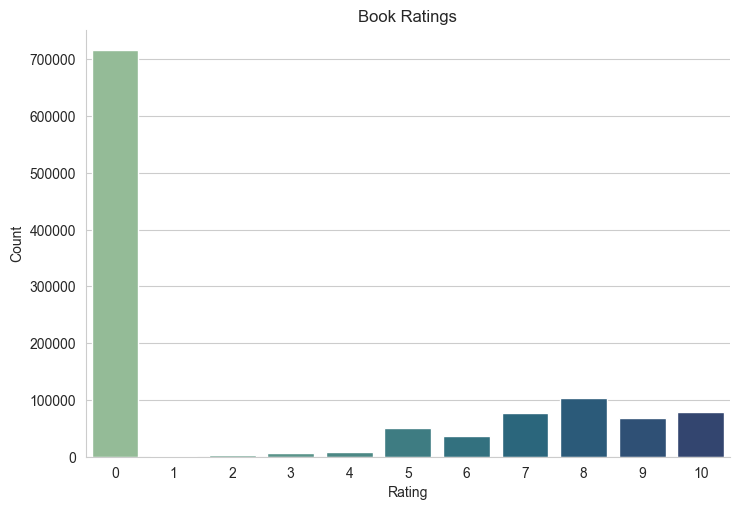

In [6]:
# Plot histogram of ratings

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('whitegrid')

# Ignore tight layout warning
warnings.filterwarnings('ignore')

g = sns.catplot(data = ratings, 
                x = 'Rating', 
                kind = 'count', 
                aspect = 1.5, 
                palette = 'crest')
g.set_axis_labels('Rating', 'Count')
plt.title('Book Ratings');

These unrated items obviously skew the mean. This will be problematic when fitting models and testing predictions, so it is necessary to remove these rows.

In [7]:
# Remove zero ratings
ratings = ratings[ratings.Rating != 0].copy()

# Reset index
ratings.reset_index(drop = True, inplace = True)

# Descriptive statistics for nonzero ratings data
ratings.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,UserID,Rating
count,433671.00,433671.00
mean,135458.74,7.60
std,80678.39,1.84
min,8.00,1.00
25%,66619.00,7.00
50%,133184.00,8.00
75%,205735.00,9.00
max,278854.00,10.00


When excluding zero, the mean rating is actually 7.6, not 2.9. This means that the majority of users rate the books favorably. This makes intuitive sense when one considers the two cases in which users would access the BookCrossing site to rate books: (1) to rate books they own and wish to track and share with others and (2) to rate books which have been shared with them through the non-commercial BookCrossing scheme. Users are not customers purchasing books, but rather people who are interested in sharing books. It seems especially unlikely that one would wish to share a book they dislike. People who encounter books with include BookCrossing labels are probably less likely to take the time to register and rate those books and even less so if they disliked the book.

The distribution of the nonzero ratings is visualized in the histogram below.

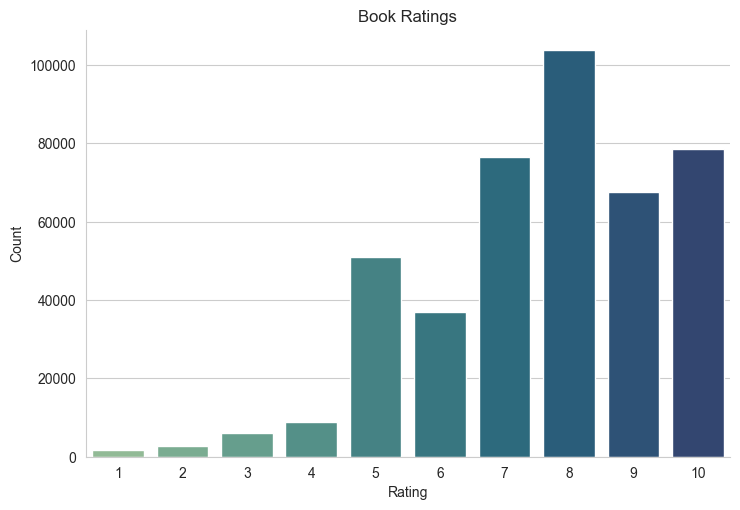

In [8]:
# Plot histogram of ratings excluding zero
g = sns.catplot(data = ratings, 
                x = 'Rating', 
                kind = 'count', 
                aspect = 1.5, 
                palette = 'crest')
g.set_axis_labels('Rating', 'Count')
plt.title('Book Ratings');

The content-based filtering model requires that each rating entry has a corresponding entry in the books data. Thus, it is necessary to remove any rows which do not satisfy this requirement.

In [9]:
# Remove ratings which do not have corresponding entries in books data
ratings = ratings[ratings.ISBN.isin(books.ISBN)].copy()

# Reset index
ratings.reset_index(drop = True, inplace = True)

# Check number of rows
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383842 entries, 0 to 383841
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   UserID  383842 non-null  int64 
 1   ISBN    383842 non-null  string
 2   Rating  383842 non-null  int64 
dtypes: int64(2), string(1)
memory usage: 8.8 MB


Surprisingly, almost 50,000 ISBNs in the ratings data did not have corresponding entries in the books data. The mean rating remains 7.6, however.

In [10]:
# Updated descriptive statistics
ratings.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,UserID,Rating
count,383842.00,383842.00
mean,136031.46,7.63
std,80482.30,1.84
min,8.00,1.00
25%,67591.00,7.00
50%,133789.00,8.00
75%,206219.00,9.00
max,278854.00,10.00


Books which have only been rated by less than four users will be of limited value when testing the models. In order to reduce computation time and avoid memory errors, I will drop these ratings as well.

In [11]:
# Remove books with less than 4 readers
ISBNcounts = ratings.ISBN.value_counts() 
ratings = ratings[~ratings.ISBN.isin(ISBNcounts[ISBNcounts < 4].index)]

# Reset index
ratings.reset_index(drop = True, inplace = True)

# Descriptive statistics for nonzero ratings data
ratings.describe().apply(lambda x: x.apply('{0:.2f}'.format))

# Updated descriptive statistics
ratings.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,UserID,Rating
count,211876.00,211876.00
mean,137221.04,7.71
std,80867.01,1.79
min,8.00,1.00
25%,68014.00,7.00
50%,135360.00,8.00
75%,208468.00,9.00
max,278854.00,10.00


Over 170,000 books had only been rated by three or fewer users. Without these, the mean rating has increased by a tenth of one point to 7.7. However, the shape of the distribution of ratings appears almost identical.

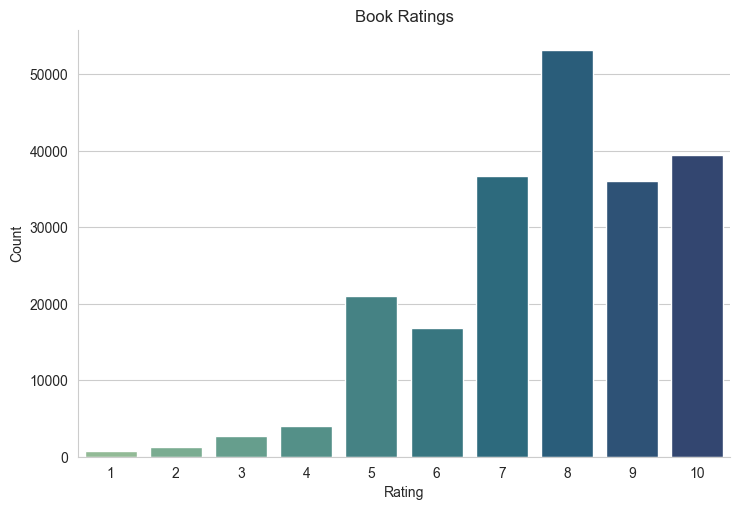

In [12]:
# Plot updated histogram of ratings

# Plot histogram of ratings excluding zero
g = sns.catplot(data = ratings, 
                x = 'Rating', 
                kind = 'count', 
                aspect = 1.5, 
                palette = 'crest')
g.set_axis_labels('Rating', 'Count')
plt.title('Book Ratings');

Depending on the findings of the exploratory analysis of the books data in the next subsection, it might become necessary to remove more ratings.

## Books

Next, I prepare and explore the books data.

In [13]:
# Check books data types and non-null counts
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ISBN       271360 non-null  string
 1   Title      271360 non-null  string
 2   Author     271358 non-null  string
 3   Year       271360 non-null  string
 4   Publisher  271358 non-null  string
 5   URLS       271360 non-null  string
 6   URLM       271360 non-null  string
 7   URLL       271357 non-null  string
dtypes: string(8)
memory usage: 16.6 MB


Comparing the number of entries with the non-null count above, we see that there are a few rows with missing values. In fact, when I first loaded the data and attempted to specify the data type of the publication year as an integer, an error was raised that stated that 'DK Publishing, Inc.' could not be safely converted to an integer.

In [14]:
# Examine rows whose year of publication is not an integer
# https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html

not_a_year = books.Year.str.contains('[A-z]+', regex = True)
not_a_year_idx = not_a_year[not_a_year].index.values
books.iloc[not_a_year_idx]

,ISBN,Title,Author,Year,Publisher,URLS,URLM,URLL
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,<NA>
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,<NA>
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,<NA>


The data in the last six columns of the three rows shown above has been erroneously shifted over one column to the left. Viewing the full titles for these rows, we see that the authors have been appended to the respective titles:

In [15]:
# View titles of these three books
titles = books.Title.iloc[not_a_year_idx].to_numpy()
for title in titles:
    print(title)

DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\";Michael Teitelbaum"
Peuple du ciel, suivi de 'Les Bergers\";Jean-Marie Gustave Le ClÃ?Â©zio"
DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\";James Buckley"


To correct this, I will shift the data to the proper columns and correct the titles and authors:

In [16]:
# Correct the data of the above three rows
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html

# Create dictionary of correct titles and authors obtained from https://www.bookcrossing.com/
corrections = {209538: {'ISBN': '078946697X',
                        'Title': 'DK Readers: Creating the X-Men, How It All Began', 
                        'Author': 'Michael Teitelbaum'}, 
               220731: {'ISBN': '2070426769',
                        'Title': "Peuple du ciel, suivi de 'Les Bergers'",
                        'Author': 'Jean-Marie Gustave Le Clézio'}, 
               221678: {'ISBN': '0789466953',
                        'Title': 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)',
                        'Author': 'James Buckley'}}

# For each index in corrections dictionary
for idx, book_dict in corrections.items():
    
    # Shift entire row one column to the right
    # (Inserts '<NA>' in leftmost column)
    books.iloc[idx] = books.iloc[idx].shift(1)
    
    # Replace the missing/incorrect values
    for feature, value in book_dict.items():
        books[feature].iloc[idx] = value

books.iloc[not_a_year_idx]

,ISBN,Title,Author,Year,Publisher,URLS,URLM,URLL
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers'",Jean-Marie Gustave Le Clézio,2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...


Now that all publication year strings are only numerals, the column can be recast to plot a histogram:

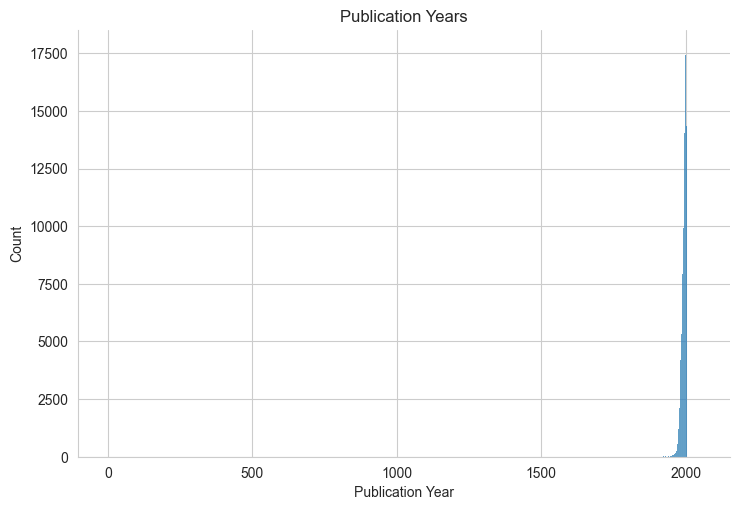

In [17]:
# Plot histogram of publication year

# Create Pandas series of year cast as integer
years = pd.DataFrame(books.Year.astype(int))

g = sns.displot(data = years, 
                x = 'Year', 
                kind = 'hist', 
                discrete = True, 
                aspect = 1.5)
g.set_axis_labels('Publication Year', 'Count')
plt.title('Publication Years');

The distribution is extremely left skewed and leptokurtic. There is a very large number of books published around the 1990s and fewer published in earlier decades. The histogram reveals that some entries have publication years as early as 1440 years before the invention of the printing press. The calculations below reveal that there are four entries with publication years between 1 and 1899 CE and 4,618 entries with the publication year set to zero. As with the ratings data, zero most likely encodes missing values. These account for less than 2 percent of all the entries, so the effect of dropping these rows from the dataset would most likely be negligible.

In [18]:
# Number of publication years earlier than 1900
pre1900_count = (years.Year < 1900).sum()
zero_year_book_count = (years.Year == 0).sum()
print(f"{pre1900_count} entries with pre-1900 publication year")
print(f"{zero_year_book_count} entries with year set to zero")
print(f"{zero_year_book_count/len(books)*100:.2f}% of entries with year set to zero")

4622 entries with pre-1900 publication year
4618 entries with year set to zero
1.70% of entries with year set to zero


Closer inspection reveals that the four entries with non-zero pre-1900 publication years are reprints but use the year the works were originally published. 

In [19]:
# View entries with publication year 1 to 1899 CE
nonzero_pre1900_publication_idx = years[years.Year.between(1,1899)].index.values
books.iloc[nonzero_pre1900_publication_idx]

,ISBN,Title,Author,Year,Publisher,URLS,URLM,URLL
171817,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable...",Benjamin Franklin,1806,Reprint Services Corp,http://images.amazon.com/images/P/0781228956.0...,http://images.amazon.com/images/P/0781228956.0...,http://images.amazon.com/images/P/0781228956.0...
227531,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...
245607,0781268001,"Hugh Wynne, Free Quaker (2 Volumes (BCL1-PS Am...",Silas Weir Mitchell,1897,Reprint Services Corp,http://images.amazon.com/images/P/0781268001.0...,http://images.amazon.com/images/P/0781268001.0...,http://images.amazon.com/images/P/0781268001.0...
253750,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376,Nashr-i Alburz,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...


Examining ten of the entries with the publication year set to zero, we see that zero appears to be encoding missing publication year values.

In [20]:
# View first five and last five rows where publication year is zero
zero_year_idx = books[books.Year == '0'].index.values
books.iloc[zero_year_idx]

,ISBN,Title,Author,Year,Publisher,URLS,URLM,URLL
176,3150000335,Kabale Und Liebe,Schiller,0,"Philipp Reclam, Jun Verlag GmbH",http://images.amazon.com/images/P/3150000335.0...,http://images.amazon.com/images/P/3150000335.0...,http://images.amazon.com/images/P/3150000335.0...
188,342311360X,Die Liebe in Den Zelten,Gabriel Garcia Marquez,0,Deutscher Taschenbuch Verlag (DTV),http://images.amazon.com/images/P/342311360X.0...,http://images.amazon.com/images/P/342311360X.0...,http://images.amazon.com/images/P/342311360X.0...
288,0571197639,Poisonwood Bible Edition Uk,Barbara Kingsolver,0,Faber Faber Inc,http://images.amazon.com/images/P/0571197639.0...,http://images.amazon.com/images/P/0571197639.0...,http://images.amazon.com/images/P/0571197639.0...
351,3596214629,"Herr Der Fliegen (Fiction, Poetry and Drama)",Golding,0,Fischer Taschenbuch Verlag GmbH,http://images.amazon.com/images/P/3596214629.0...,http://images.amazon.com/images/P/3596214629.0...,http://images.amazon.com/images/P/3596214629.0...
542,8845229041,Biblioteca Universale Rizzoli: Sulla Sponda De...,P Coelho,0,Fabbri - RCS Libri,http://images.amazon.com/images/P/8845229041.0...,http://images.amazon.com/images/P/8845229041.0...,http://images.amazon.com/images/P/8845229041.0...
...,...,...,...,...,...,...,...,...
270794,014029953X,Foe (Essential.penguin S.),J.M. Coetzee,0,Penguin Books Ltd,http://images.amazon.com/images/P/014029953X.0...,http://images.amazon.com/images/P/014029953X.0...,http://images.amazon.com/images/P/014029953X.0...
270913,0340571187,Postmens House,Maggie Hemingway,0,Trafalgar Square,http://images.amazon.com/images/P/0340571187.0...,http://images.amazon.com/images/P/0340571187.0...,http://images.amazon.com/images/P/0340571187.0...
271094,8427201079,El Misterio De Sittaford,Agatha Christie,0,Editorial Molino,http://images.amazon.com/images/P/8427201079.0...,http://images.amazon.com/images/P/8427201079.0...,http://images.amazon.com/images/P/8427201079.0...
271182,0887781721,Tom Penny,Tony German,0,P. Martin Associates,http://images.amazon.com/images/P/0887781721.0...,http://images.amazon.com/images/P/0887781721.0...,http://images.amazon.com/images/P/0887781721.0...


Because it would be time consuming to determine the correct publication year for 4,618 books, I drop these rows from the data. This also necessitates removing about 3,000 ratings which no longer have corresponding entries in the books data. 

In [21]:
# Removing books with publication year of zero
books.drop(zero_year_idx, inplace = True)

# Reset index
books.reset_index(drop = True, inplace = True)

# Remove ratings which do not have corresponding entries in books data
ratings = ratings[ratings.ISBN.isin(books.ISBN)].copy()

# Reset index
ratings.reset_index(drop = True, inplace = True)

# Check number of rows in ratings data
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209284 entries, 0 to 209283
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   UserID  209284 non-null  int64 
 1   ISBN    209284 non-null  string
 2   Rating  209284 non-null  int64 
dtypes: int64(2), string(1)
memory usage: 4.8 MB


There are no longer three missing values for the large image URLs, but there are still two missing values for author and publisher each:

In [22]:
# Check non-null count of books data
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266742 entries, 0 to 266741
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ISBN       266742 non-null  string
 1   Title      266742 non-null  string
 2   Author     266740 non-null  string
 3   Year       266742 non-null  string
 4   Publisher  266740 non-null  string
 5   URLS       266742 non-null  string
 6   URLM       266742 non-null  string
 7   URLL       266742 non-null  string
dtypes: string(8)
memory usage: 16.3 MB


In [23]:
# Examine rows with missing values
missing_idx = books[books.isna().any(axis = 1)].index.values
books.iloc[missing_idx]

,ISBN,Title,Author,Year,Publisher,URLS,URLM,URLL
115930,0751352497,A+ Quiz Masters:01 Earth,<NA>,1999,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...
126627,193169656X,Tyrant Moon,Elaine Corvidae,2002,<NA>,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
126774,1931696993,Finders Keepers,Linnea Sinclair,2001,<NA>,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...
184409,9627982032,The Credit Suisse Guide to Managing Your Perso...,<NA>,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


An [Open Library](https://openlibrary.org) search confirms that the two titles do not have authors and also reveals the names of the missing publishers. I will set the missing authors to the publishers' names and add the missing publishers.

In [24]:
# Fix authors and publishers
# References:
# https://openlibrary.org/books/OL10813652M/A_Quiz_Masters
# https://openlibrary.org/books/OL9820843M/Tyrant_Moon
# https://openlibrary.org/works/OL34784814W/Finders_Keepers
# https://openlibrary.org/books/OL9161436M/The_Credit_Suisse_Guide_to_Managing_Your_Personal_Wealth

books.Author.iloc[missing_idx[0]] = books.Publisher.iloc[missing_idx[0]]
books.Publisher.iloc[missing_idx[1]] = 'Novel Books, Inc.'
books.Publisher.iloc[missing_idx[2]] = 'CreateSpace Independent Publishing Platform'
books.Author.iloc[missing_idx[3]] = books.Publisher.iloc[missing_idx[3]]

books.iloc[missing_idx]

,ISBN,Title,Author,Year,Publisher,URLS,URLM,URLL
115930,0751352497,A+ Quiz Masters:01 Earth,Dorling Kindersley,1999,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...
126627,193169656X,Tyrant Moon,Elaine Corvidae,2002,"Novel Books, Inc.",http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
126774,1931696993,Finders Keepers,Linnea Sinclair,2001,CreateSpace Independent Publishing Platform,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...
184409,9627982032,The Credit Suisse Guide to Managing Your Perso...,Edinburgh Financial Publishing,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


Now, there are no missing values in the books data.

In [25]:
# Recheck books data types and non-null counts
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266742 entries, 0 to 266741
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ISBN       266742 non-null  string
 1   Title      266742 non-null  string
 2   Author     266742 non-null  string
 3   Year       266742 non-null  string
 4   Publisher  266742 non-null  string
 5   URLS       266742 non-null  string
 6   URLM       266742 non-null  string
 7   URLL       266742 non-null  string
dtypes: string(8)
memory usage: 16.3 MB


In [26]:
# Remove unneeded objects to free memory
import gc
del not_a_year
del not_a_year_idx
del years
del nonzero_pre1900_publication_idx
del zero_year_idx
del missing_idx
print('Number of unreachable objects:')
gc.collect()

Number of unreachable objects:


3930

Although it might be interesting to use deep learning on the book covers to predict ratings, at least some (if not all) of the URLs no longer direct to the book cover images, as the reader can verify with the following example.

In [27]:
# Non-functioning URL example
books.iloc[188].URLM

'http://images.amazon.com/images/P/3423241489.01.MZZZZZZZ.jpg'

Therefore, we can drop these columns from the dataframe.

In [28]:
# Drop URL columns
books.drop(columns = ['URLS', 'URLM', 'URLL'], inplace = True)
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266742 entries, 0 to 266741
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ISBN       266742 non-null  string
 1   Title      266742 non-null  string
 2   Author     266742 non-null  string
 3   Year       266742 non-null  string
 4   Publisher  266742 non-null  string
dtypes: string(5)
memory usage: 10.2 MB


Content-based filtering requires the calculation of similarities between items, often using a similarity matrix. Depending on the sparseness of the item matrix, memory constraints could become problematic. Therefore, it would be best to reduce the size of the books data if possible. The aim of this project is to compare model effectiveness using the existing ratings. Therefore, only the books for which ratings exist are needed, and the others can be discarded.

In [29]:
# Remove books which do not occur in the ratings data
books = books[books.ISBN.isin(ratings.ISBN)].copy()

# Reset index
books.reset_index(drop = True, inplace = True)

# Descriptive statistics for books data
books.describe()

,ISBN,Title,Author,Year,Publisher
count,18376,18376,18376,18376,18376
unique,18376,16332,6520,69,1315
top,0002005018,Pride and Prejudice,Stephen King,2002,Ballantine Books
freq,1,7,190,1818,670


Descriptive statistics for the books data show that even though all of the ISBNs are unique, not all of the titles are. The most frequent title is "Pride and Prejudice" which accounts for 7 of the books. In addition, over 437 of the books are authored by Stephen King, 2002 is the most frequent publication year, and Ballantine Books is the most common publisher.

In order to use this categorical data in a content-based filtering model, it will be necessary to vectorize it. Although we could treat each unique author and publisher entry as a separate category, as the examples below illustrate, there are variations of both author and publisher names which refer to the same person or publisher respectively.

In [30]:
# Books written by Alan Alexander Milne
books[books.Author == 'Alan Alexander Milne'].head()

,ISBN,Title,Author,Year,Publisher
8210,0525444440,The House at Pooh Corner,Alan Alexander Milne,1988,Dutton Books


In [31]:
# Books written by Alan Alexander Milne attributed to A. A. Milne
books[books.Author == 'A. A. Milne'].head()

,ISBN,Title,Author,Year,Publisher
8505,0140361227,The House at Pooh Corner,A. A. Milne,1992,Puffin Books
8933,0394825691,Walt Disneys Winnie the Pooh and Tigger Too (D...,A. A. Milne,1976,Random House Children's Books
12398,157082262X,Where's Piglet? (Mouse Works Peek-a-Pooh Book),A. A. Milne,1995,Mouse Works
13444,3423703954,Pu Der Bar,A. A. Milne,1999,Deutscher Taschenbuch Verlag
16199,0486401294,The Red House Mystery (Dover Mystery Classics),A. A. Milne,1998,Dover Publications


In [32]:
# Books published by "Penguin"
books[books.Publisher == 'Penguin'].head()

,ISBN,Title,Author,Year,Publisher
17627,0140174214,The Picturegoers,David Lodge,1993,Penguin


In [33]:
# Books published by "Penguin Books"
books[books.Publisher == 'Penguin Books'].head()

,ISBN,Title,Author,Year,Publisher
33,0140067477,The Tao of Pooh,Benjamin Hoff,1983,Penguin Books
198,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
248,014023828X,The Tortilla Curtain,T. Coraghessan Boyle,1996,Penguin Books
305,0140286276,The Deep End of the Ocean (Oprah's Book Club),Jacquelyn Mitchard,1999,Penguin Books
382,0140293248,The Girls' Guide to Hunting and Fishing,Melissa Bank,2000,Penguin Books


Similarly, there are keywords in some titles which occur in other titles. For example, book titles containing "Pooh" will be of interest to readers who like "Winnie the Pooh."

In [34]:
# Books with titles containing "Pooh"
books[books.Title.str.contains('Pooh')].head(10)

,ISBN,Title,Author,Year,Publisher
33,0140067477,The Tao of Pooh,Benjamin Hoff,1983,Penguin Books
2729,0525244581,The Tao of Pooh,Benjamin Hoff,1982,Dutton Books
5531,0140361219,Winnie-The-Pooh,A.A. Milne,1992,Puffin Books
6982,0525455205,Pooh and the Philosophers : In Which It Is Sho...,John Tyerman Williams,1996,Dutton Books
8210,0525444440,The House at Pooh Corner,Alan Alexander Milne,1988,Dutton Books
8505,0140361227,The House at Pooh Corner,A. A. Milne,1992,Puffin Books
8933,0394825691,Walt Disneys Winnie the Pooh and Tigger Too (D...,A. A. Milne,1976,Random House Children's Books
9928,0307302016,Winnie the Pooh and the Honey Tree (Little Gol...,Golden Books,1995,Western Publishing Company
11110,0307987655,"Eeyore, You're the Best (Disney's Pooh)",Ann Braybrooks,1996,Random House Childrens Books
11112,0307987981,Pooh and the Dragon (Little Golden Book),Ann Braybrooks,1997,Golden Books Publishing Company


As the examples above demonstrate, the strings within the title, author, and publisher elements contain information which could be useful in finding similar books. Therefore, I will vectorize the data by creating binary vectors of words that occur more than once for a given feature but do not occur in more than 30% of the rows and do not include common non-content English words such as "and" or "the" Then, I combine these vectors with the binary encoding of the publication year to create binary vectors characterizing each book. 

As an example, the vector for _The Tao of Pooh_ book (ISBN: 0140067477) listed above would likely have ones in the derived features corresponding to "Tao," "Pooh," "Benjamin," "Hoff," "1983," "Penguin," and "Books." Comparing such a vector to the vector for the edition of the same title and author published one year earlier by a different publisher should theoretically result in a Jaccard similarity index of 3/4.

The following class implements this binary vectorization method and computes the Jaccard similarity matrix.

In [35]:
# Create binary vectors of books data
# References:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# https://scikit-learn.org/stable/modules/feature_extraction.html#using-stop-words
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.hstack.html

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, issparse
import numpy as np

# Print Sci-Kit Learn English stop word list for inspection
print('Stop word list:', sorted(ENGLISH_STOP_WORDS))

class BinaryBooksVectors:
    '''
    Binary books vectors class to vectorize title, author, publisher, and publication year
    and to compute a Jaccard similarity matrix for those vectors
    '''
    def __init__(self, max_df = 0.3, stop_words = 'english', min_df = 2, binary = True, verbose = True): 
        '''
        Initialize vectorization parameters
        '''
        # Ignore words occurring in more than max_df of documents 
        self.max_df = max_df    

        # Ignore non-content words (e.g., "and", "the")
        self.stop_words = stop_words 
        
        # Ignore terms that occur in fewer than 2 documents
        self.min_df = min_df

        # Binary vector (1 if word occurs, 0 otherwise)
        self.binary = True

        # Verbose output
        self.verbose = verbose

    def titles(self):
        '''
        Vectorize titles using word counts
        Returns sparse CSR matrix
        '''
        titles = CountVectorizer(stop_words = self.stop_words,
                                 max_df = self.max_df,
                                 min_df = self.min_df,
                                 binary = self.binary
                                 ).fit_transform(books.Title)
        
        if self.verbose:
            print('Title matrix shape:', titles.shape)
        
        return titles

    def authors(self):
        '''
        Vectorize authors using word counts
        Returns sparse CSR matrix
        '''
        authors = CountVectorizer(stop_words = self.stop_words,
                                  max_df = self.max_df,
                                  min_df = self.min_df,
                                  binary = self.binary
                                  ).fit_transform(books.Author)
        
        if self.verbose:
            print('Author matrix shape:', authors.shape)
        
        return authors

    def publishers(self):
        '''
        Vectorize publishers using word counts
        Returns sparse CSR matrix
        '''
        publishers = CountVectorizer(stop_words = self.stop_words,
                                     max_df = self.max_df,
                                     min_df = self.min_df,
                                     binary = self.binary
                                     ).fit_transform(books.Publisher)
        
        if self.verbose:
            print('Publisher matrix shape:', publishers.shape)
        
        return publishers

    def years(self):
        '''
        Vectorize publication years using one-hot-encoding
        Returns sparse CSR matrix
        '''
        years = OneHotEncoder().fit_transform(books.Year.astype(int).to_numpy().reshape(-1, 1))
        
        if self.verbose:
            print('Publication year matrix shape:', years.shape)
        
        return years

    def vectorize(self):
        '''
        Vectorize books data by stacking 
        title, author, publisher, and year vectors
        Returns sparse CSR matrix
        '''
        # Stack sparse matrices
        books_matrix = hstack([self.titles(), 
                               self.authors(), 
                               self.publishers(), 
                               self.years()])

        # Recast matrix as unsigned 8-bit integer
        books_matrix = books_matrix.astype(np.uint8)

        if self.verbose:
            print('Combined matrix shape:', books_matrix.shape)
        
            self.print_sparsity(books_matrix)

        return books_matrix

    def print_sparsity(self, X):
        '''
        Print sparse matrix type and
        percentage of zero elements in sparse matrix
        '''
        if issparse(X):
            print('Matrix type:', X.getformat())

            # Calculate percent sparsity
            sparsity = (1 - X.nnz / np.prod(X.shape)) * 100

            print(f'Sparsity: {sparsity:.2f}%')
        
        else:
            print('Matrix type: dense')

    def similarities(self):
        '''
        Return item-item Jaccard similarities as sparse matrix
        '''
        # Compute similarities from vectorized item data
        similarities = self.jaccard_similarity(self.vectorize())

        if self.verbose:
            print('Similarity matrix shape:', similarities.shape)
        
            self.print_sparsity(similarities)
        
        return similarities

    def jaccard_similarity(self, X):
        '''
        Compute sparse Jaccard index matrix from binary data
        '''
        # References: 
        # https://en.wikipedia.org/wiki/Jaccard_index
        # https://stackoverflow.com/a/53013222/14371011
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_array.html        
                
        # Compute row-to-row intersections, |X_i \cap X_j|
        intersections = X.dot(X.T)
        
        # Obtain row sums, |X_i| = |X_j| 
        # (equivalent to diagonal of intersection matrix)
        row_sums = intersections.diagonal()
        
        # Compute unions: |X_i \cup X_j| = |X_i| + |X_j| - |X_i \cap X_j|
        unions = row_sums.reshape(-1,1) + row_sums - intersections
        
        # Ignore division by zero warning because NaNs
        # will be replaced with ones in the next step
        with np.errstate(divide = 'ignore'):
            # Jaccard similarities, J = |X_i \cap X_j|/|X_i \cup X_j|
            J = (intersections / unions)

        # A vector is maximally similar to itself,
        # so replace any NaNs on diagonal with 1
        J.setdiag(1)

        # Return as sparse CSR matrix
        return J.asformat('csr')

# Compute Jaccard similarity matrix for binary
# title, author, publisher, and year vectors
similarities = BinaryBooksVectors().similarities()

# Find nine books with most similar vectors to "The Tao of Pooh"
tao_pooh_idx = books[books.Title.str.contains('The Tao of Pooh')].index[0]
idx = (-similarities.getrow(tao_pooh_idx).toarray()).argsort().reshape(-1,)
books.iloc[idx].head(10)


Stop word list: ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 'furthe

Publisher matrix shape: (18376, 716)
Publication year matrix shape: (18376, 69)
Combined matrix shape: (18376, 10467)
Matrix type: csr
Sparsity: 99.93%
Similarity matrix shape: (18376, 18376)
Matrix type: csr
Sparsity: 89.85%


,ISBN,Title,Author,Year,Publisher
33,0140067477,The Tao of Pooh,Benjamin Hoff,1983,Penguin Books
2729,0525244581,The Tao of Pooh,Benjamin Hoff,1982,Dutton Books
6378,0140230165,The Te of Piglet,Benjamin Hoff,1993,Penguin Books
2828,0140063838,Clinging to the Wreckage,John Mortimer,1983,Penguin Books Ltd
3827,0140067779,Obasan,Joy Kogawa,1983,Penguin Books
11641,0140062718,The Rebel Angels,Robertson Davies,1983,Penguin Books
3744,0525934960,The Te of Piglet,Benjamin Hoff,1992,Dutton Books
4069,0451128370,Christine,Stephen King,1983,Penguin Putnam~mass
3972,0452254345,Growing Up,Russell Baker,1983,Penguin Putnam~trade
15593,0451128389,Christine,Stephen King,1983,Penguin Putnam~mass


The books are now characterized by binary vectors of 10,467 derived features instead of the 24,236 features that would have been derived by encoding the unique titles, authors, publishers, and publication years.

The table above lists the ten books with the highest Jaccard similarities to _The Tao of Pooh_ (including the book itself). As expected, the two _Tao of Pooh_ books are the most similar followed by other books published by the same author. However, even though the horror novel _Christine_ was published in the same year by the same publisher, these are obviously very different books in thematically.

More nuance is needed in the vectorization. Next, I explore weighting the title by one, the author by half, the publisher by one-fifth, and the publication year by a tenth. Because the vectors are no longer binary, cosine similarity is used.

In [36]:
# Compute cosine similarities for weighted binary title, author, publisher, year vectors

from sklearn.metrics.pairwise import cosine_similarity

class WeightedBooksVectors(BinaryBooksVectors):
    '''
    Class to weight binary title, author, publisher, and year vectors
    and to compute cosine similarity matrix 
    '''
    def __init__(self, max_df = 0.3, stop_words = 'english', min_df = 2, binary = True, 
                 verbose = True, title_wt = 1, author_wt = 0.5, pub_wt = 0.2, yr_wt = 0.1):
        super().__init__(max_df, stop_words, min_df, binary, verbose)
        self.title_wt = title_wt
        self.author_wt = author_wt
        self.pub_wt = pub_wt
        self.yr_wt = yr_wt
    
    def vectorize(self):
        '''
        Vectorize books data by stacking weighted
        title, author, publisher, and year vectors
        Returns sparse CSR matrix
        '''
        # Stack sparse matrices
        books_matrix = hstack([self.titles().multiply(self.title_wt), 
                               self.authors().multiply(self.author_wt), 
                               self.publishers().multiply(self.pub_wt), 
                               self.years().multiply(self.yr_wt)])

        if self.verbose:
            print('Combined matrix shape:', books_matrix.shape)
        
            self.print_sparsity(books_matrix)

        return books_matrix

    def similarities(self):
        '''
        Return item-item cosine similarities as dense matrix
        '''
        # Compute cosine similarity matrix scaled to [0,1]
        similarities = 0.5 + 0.5 * cosine_similarity(self.vectorize(), 
                                                     dense_output = True)
        
        if self.verbose:
            print('Similarity matrix shape:', similarities.shape)
               
        return similarities
    
# Compute Jaccard similarity matrix for weighted
# title, author, publisher, and year vectors
similarities = WeightedBooksVectors().similarities()

# Find nine books with most similar vectors to "The Tao of Pooh"
idx = (-similarities[tao_pooh_idx]).argsort()
books.iloc[idx].head(10)

Title matrix shape: (18376, 6549)
Author matrix shape: (18376, 3133)
Publisher matrix shape: (18376, 716)
Publication year matrix shape: (18376, 69)
Combined matrix shape: (18376, 10467)
Matrix type: csr
Sparsity: 99.93%
Similarity matrix shape: (18376, 18376)


,ISBN,Title,Author,Year,Publisher
33,0140067477,The Tao of Pooh,Benjamin Hoff,1983,Penguin Books
2729,0525244581,The Tao of Pooh,Benjamin Hoff,1982,Dutton Books
2268,1570625190,The Tao of Physics,FRITJOF CAPRA,2000,Shambhala
5531,0140361219,Winnie-The-Pooh,A.A. Milne,1992,Puffin Books
8505,0140361227,The House at Pooh Corner,A. A. Milne,1992,Puffin Books
12039,1885222556,Disneys Out and About With Pooh Volume 1,Disney Enterprises Inc,1996,"Advance Publishing, Inc"
7304,0060812451,Tao Te Ching,Stephen Mitchell,1992,Perennial
14041,156282015X,Disney's Winnie the Pooh's A to ZZzz,Don Ferguson,1992,Disney Pr
8210,0525444440,The House at Pooh Corner,Alan Alexander Milne,1988,Dutton Books
7938,0062502239,365 Tao : Daily Meditations,Ming-Dao Deng,1992,HarperSanFrancisco


This is an improvement. These books seem to be more relevant than horror novels. Each is related to Taoism or Winnie the Pooh (or both). It is worth noting that _The Tao of Pooh_ is aimed at an adult audience interested in Taoism, but capturing this cultural background knowledge from titles alone is obviously impossible. One disadvantage to this vectorization is that the similarity matrix is no longer sparse, consuming more memory.

For this set of results at least, the publisher name and year seem to be largely irrelevant. Additionally, books with authors of the same given name are not necessarily similar. Thus, it might be possible to achieve the same or better results with fewer features in binary form and with a sparse matrix, reducing the amount of calculations and memory used. Next, I extract the surname and create binary vectors with only the title and surname.

In [37]:
# Create similarity matrix based on titles and author surnames only

class BinaryTitleSurnameVectors(BinaryBooksVectors):
    '''
    Class to create binary vectors of title and author surnames
    and to compute Jaccard similarity matrix
    '''
    def __init__(self, max_df = 0.3, stop_words = 'english', min_df = 2, binary = True, verbose = True):
        super().__init__(max_df, stop_words, min_df, binary, verbose)

    def surnames(self):
        '''
        Vectorize author surnames using word counts
        Returns sparse CSR matrix
        '''
        surnames = CountVectorizer(stop_words = self.stop_words,
                                   max_df = self.max_df,
                                   min_df = self.min_df,
                                   binary = self.binary
                                   ).fit_transform(books.Author.
                                                   apply(lambda x: 
                                                         x.split(' ')[-1]))
        
        if self.verbose:
            print('Author surname matrix shape:', surnames.shape)
        
        return surnames

    def vectorize(self):
        '''
        Vectorize books data by stacking 
        title and author surname vectors
        Returns sparse CSR matrix
        '''
        # Stack sparse matrices
        books_matrix = hstack([self.titles(), self.surnames()])

        # Recast matrix as unsigned 8-bit integer
        books_matrix = books_matrix.astype(np.uint8)

        if self.verbose:
            print('Combined matrix shape:', books_matrix.shape)
        
            self.print_sparsity(books_matrix)

        return books_matrix

# Compute Jaccard similarity matrix for binary
# title and author surname vectors
similarities = BinaryTitleSurnameVectors().similarities()

# Find nine books with most similar vectors to "The Tao of Pooh"
idx = (-similarities.getrow(tao_pooh_idx).toarray()).argsort().reshape(-1,)
books.iloc[idx].head(10)

Title matrix shape: (18376, 6549)
Author surname matrix shape: (18376, 2051)
Combined matrix shape: (18376, 8600)
Matrix type: csr
Sparsity: 99.95%
Similarity matrix shape: (18376, 18376)
Matrix type: csr
Sparsity: 98.42%


,ISBN,Title,Author,Year,Publisher
2729,0525244581,The Tao of Pooh,Benjamin Hoff,1982,Dutton Books
33,0140067477,The Tao of Pooh,Benjamin Hoff,1983,Penguin Books
2268,1570625190,The Tao of Physics,FRITJOF CAPRA,2000,Shambhala
12114,0064440028,Danny and the Dinosaur,Syd Hoff,1992,HarperTrophy
5531,0140361219,Winnie-The-Pooh,A.A. Milne,1992,Puffin Books
3744,0525934960,The Te of Piglet,Benjamin Hoff,1992,Dutton Books
12039,1885222556,Disneys Out and About With Pooh Volume 1,Disney Enterprises Inc,1996,"Advance Publishing, Inc"
6378,0140230165,The Te of Piglet,Benjamin Hoff,1993,Penguin Books
14041,156282015X,Disney's Winnie the Pooh's A to ZZzz,Don Ferguson,1992,Disney Pr
7304,0060812451,Tao Te Ching,Stephen Mitchell,1992,Perennial


In terms of similarity, this might be worse by one book. _The Te of Piglet_ and a book by a different author with the same surname have replaced the _365 Tao_ and _The House at Pooh Corner_. (Incidentally, depending on the application, it might be desireable to suppress duplicates when recommending books based on purchases already made.) However, in terms of the number of features and sparsity of the similarity matrix, this is an improvement.

For further comparison, I explore the effectiveness of deriving the [term frequency–inverse document frequency (TF-IDF)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) statistic on the combined title and author surname. TF-IDF increases in proportion to the number of occurences of a word in a particular text offset by its frequency in the corpus overall, so it is often used to approximate document topic. The resulting vector is L2 normalized, so the dot product can be used to obtain the cosine similarity.

In [38]:
# Compute cosine similarity of TF-IDF vectors of title and author surname

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.feature_extraction.text import TfidfVectorizer

class TitleSurnameTFIDFVectors(BinaryBooksVectors):
    '''
    Class to create TF-IDF vectors of title and author surname combined
    and to compute cosine similarity matrix (scaled to [0,1])
    '''
    def __init__(self, max_df = 0.3, stop_words = 'english', min_df = 2, binary = False, verbose = True):
        super().__init__(max_df, stop_words, min_df, binary, verbose)

    def vectorize(self):
        '''
        Compute L2 normalized TF-IDF vectors of title 
        and author surname combined
        Return sparse CSR matrix
        '''
        tfidf = TfidfVectorizer(stop_words = self.stop_words,
                                max_df = self.max_df,
                                min_df = self.min_df,
                                norm = 'l2'
                                ).fit_transform(books.Title + ' ' 
                                                + books.Author.apply(lambda x: 
                                                                     x.split(' ')[-1]))

        if self.verbose:
            print('Topics matrix shape:', tfidf.shape)
        
            self.print_sparsity(tfidf)

        return tfidf

    def similarities(self):
        '''
        Return dense item-item cosine similarity matrix (scaled to [0,1])
        for TF-IDF of title and author surname vectors combined
        '''
        # Get normalized TF-IDF vectors of title and 
        # author surname combined
        tfidf = self.vectorize()

        # Cosine similarity is dot product of normalized vector
        # scale to [0,1] by dividing elements by 2 and adding 1/2
        similarities = (tfidf.dot(tfidf.T) * 0.5).toarray() + 0.5

        if self.verbose:
            print('Similarity matrix shape:', similarities.shape)

        return similarities

# Compute cosine similarity matrix (scaled to [0,1]) for
# TF-IDF vectors of title and author surname combined
similarities = TitleSurnameTFIDFVectors().similarities()

# Find nine books with most similar vectors to "The Tao of Pooh"
idx = (-similarities[tao_pooh_idx]).argsort()
books.iloc[idx].head(10)

Topics matrix shape: (18376, 8343)
Matrix type: csr
Sparsity: 99.95%
Similarity matrix shape: (18376, 18376)


,ISBN,Title,Author,Year,Publisher
33,0140067477,The Tao of Pooh,Benjamin Hoff,1983,Penguin Books
2729,0525244581,The Tao of Pooh,Benjamin Hoff,1982,Dutton Books
2268,1570625190,The Tao of Physics,FRITJOF CAPRA,2000,Shambhala
6982,0525455205,Pooh and the Philosophers : In Which It Is Sho...,John Tyerman Williams,1996,Dutton Books
3744,0525934960,The Te of Piglet,Benjamin Hoff,1992,Dutton Books
6378,0140230165,The Te of Piglet,Benjamin Hoff,1993,Penguin Books
12114,0064440028,Danny and the Dinosaur,Syd Hoff,1992,HarperTrophy
12039,1885222556,Disneys Out and About With Pooh Volume 1,Disney Enterprises Inc,1996,"Advance Publishing, Inc"
5531,0140361219,Winnie-The-Pooh,A.A. Milne,1992,Puffin Books
7304,0060812451,Tao Te Ching,Stephen Mitchell,1992,Perennial


These are the same books in a slightly different order. Fewer features were required to arrive at almost the same results, but the similarity matrix is no longer sparse. 

The exploratory comparisons in this subsection have been based on similarity to a single book. Therefore, choice of vectorization should be explored more thoroughly in the main analysis.

## Users
In the data description at the beginning of this report, some problems with nonsensical locations were already observed in the users data. Here, I examine this data in more detail.

First, I remove the users which do not have corresponding entries in the ratings data as such users will be irrelevant to the main analysis.

In [39]:
# Remove users which do not have corresponding entries in ratings data
users = users[users.UserID.isin(ratings.UserID)].copy()

# Reset index
users.reset_index(drop = True, inplace = True)

# Check users data types and non-null values
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49355 entries, 0 to 49354
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   UserID    49355 non-null  int64  
 1   Location  49355 non-null  string 
 2   Age       29321 non-null  float64
dtypes: float64(1), int64(1), string(1)
memory usage: 1.1 MB


Roughly 40% of the users data is missing ages.

In [40]:
# Percent missing age values
print(f"Age: {users.Age.isnull().sum()/len(users)*100:.2f}% missing")

Age: 40.59% missing


In the histogram of user ages below, there is a very unlikely number of newborn and centenarian bibliophiles.

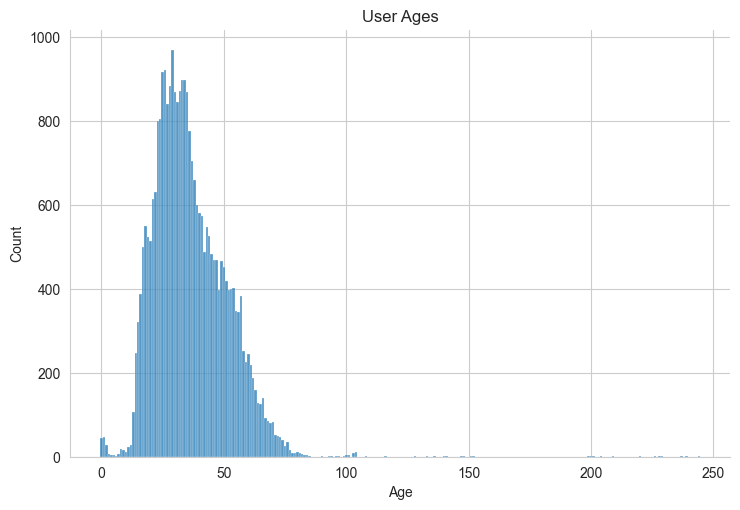

In [41]:
# Plot histogram of user age
g = sns.displot(data = users, x = 'Age', kind = 'hist', discrete = True, aspect = 1.5)
g.set_axis_labels('Age', 'Count')
plt.title('User Ages');

Dubious ages aside, one plausible explanation for the right skewness of the distribution within the range of natural human ages is that older people are less likely to use the BookCrossing website to track book exchanges. Another is that older people might be more reluctant to share their age.

The problem remains though that about 40% of the ages are missing, and some of those that are present are most likely false. We could replace these values with the mean, but this would result in extremely high kurotosis, which could have a considerable impact on the model.

In addition to these problems, as I mentioned in the introduction, memory-based collaborative-based filtering is difficult to scale. Furthermore, memory-based user-similarity collaborative filtering is generally less effective than item-similarity collaborative filtering because users can have eclectic tastes. Taking all of this into consideration, it does not appear to be worthwhile to incorporate the user data in any models.

In [42]:
# Free memory
del similarities
del idx
del users
print('Number of unreachable objects:')
gc.collect()

Number of unreachable objects:


124358

## Exploratory Analysis Summary
In this section, I have explored and prepared the data for the main analysis. The ratings and books data have been reduced to only those items with complete data and more than three ratings per book. Four possible vectorizations of the categorical book features have been preliminarily explored. The relative effectiveness of these vectorizations will need to be compared as part of the main analysis. Due to problems with the user age and location data and the limitations of memory-based user-similarity collaborative filtering, the user metadata will not be part of the main analysis.

# Models

As stated in the introduction, the aim of this project is to compare the effectiveness of normal (i.e., Gaussian) predictor, content-based, baseline estimate (Koren, 2010), slope one (Lemire & Machlachlan, 2005), singular value decomposition (SVD; Koren et al., 2009), non-negative matrix factorization (NMF; Zhang et al., 2006) recommender models. These models were chosen as commonly implemented recommender systems which can be easily implemented and scaled with large data sets. 

K-folds cross-validation will be used to compare the models. Because collaborative filtering models require at least some rating data for each item and user, data cannot simply be split by item or user. Rather, there must be some overlap in users and items in both sets. This is obviously a complex procedure for even one train-test split let alone several cross-validation iterations. Therefore, I will use the [`scikit-surprise`](https://pypi.org/project/scikit-surprise/) library (Hug, 2020), which includes cross-validation and parameter search methods.

The library's normal predictor model will be used as a relatively unsophisticated "baseline" for comparison, but this should not be confused with the baseline estimate model. It makes random predictions selected from an assumed Gaussian distribution of the ratings data. As demonstrated in the exploratory analysis, the ratings in this data set are not normally distributed, so this model is not expected to perform well.

The library does not include a content-based algorithm, but this can be implemented as shown in the code block below. The library includes a baseline estimate model which can be trained with L2 regularization. Note that "baseline estimate" refers to the adjustment of the global mean by item and user means and should not be confused with a "baseline" model for comparison. The library also implements the model-based collaborative filtering slope one, SVD, and NMF models. These latter five model are expected to perform better than the normal predictor model.

It is worth noting here that the library also includes a k-nearest neighbors memory-based collaborative filtering algorithms, but even after removing over 80% of the ratings data, it exceeds system memory and crashes the Jupyter kernel, demonstrating the advantage of model-based collaborative filtering.

In [43]:
# Content-based filtering model
# References:
# https://surprise.readthedocs.io/en/stable/building_custom_algo.html
# https://surprise.readthedocs.io/en/stable/building_custom_algo.html#when-the-prediction-is-impossible
# https://surprise.readthedocs.io/en/stable/trainset.html
# https://www.alldatascience.com/nlp/using-nlp-to-create-a-recommender-system/
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
            
from surprise import AlgoBase, PredictionImpossible

class ContentFilter(AlgoBase):
    '''
    Content-based filtering recommender
    Predicts user rating based on user's 
    ratings of similar items
    '''
    def __init__(self, item_vector_model):
        '''
        Initialize model with item vectorization model
        '''

        # Initialize base method
        AlgoBase.__init__(self)

        # Item vectorization model
        self.item_vector_model = item_vector_model

    def fit(self, trainset):
        '''
        Fit training set
        '''
        # Fit training set to base method
        AlgoBase.fit(self, trainset)

        # Calculate item similarities
        self.similarities = self.item_vector_model.similarities()

        return self

    def estimate(self, sprse_userid, sprse_itemid):
        '''
        Return estimated rating for user and item
        '''
        # If user or item are not in training set
        if (not self.trainset.knows_user(sprse_userid) or not self.trainset.knows_item(sprse_itemid)):

            # Raise exception and return rating
            # according to AlgoBase.default_prediction()
            # Default is global mean rating (trainset.global_mean)
            raise PredictionImpossible("User and/or item is unknown.")
            
        # Get scikit-surprise item IDs and ratings for this user
        sprse_iids, user_ratings = np.array(self.trainset.ur[sprse_userid]).astype(int).T

        # Get number of items
        n_items = len(sprse_iids)

        # If no ratings for this user
        if n_items == 0:

            # Get scikit-surprise user IDs and ratings for this item
            sprse_uids, ratings = np.array(self.trainset.ir[sprse_itemid]).astype(int).T
            
            # Return mean item rating
            return ratings.mean()
        
        else:
            # # Slightly slower if the following is included:
            # # If item has already been rated by this user
            # if np.isin(sprse_iids, sprse_itemid).sum() > 0:
                
            #     # Return user's rating for the item
            #     return user_ratings[np.where(sprse_iids == sprse_itemid)][0]

            # Get item ID
            itemid = self.trainset.to_raw_iid(sprse_itemid)

            # Get similarities for this item
            item_sim = self.similarities[itemid]

            # If sparse matrix:
            if issparse(item_sim):

                # Make dense
                item_sim = item_sim.toarray().reshape(-1,)

            # Get IDs of other items rated by user
            itemids = np.array([self.trainset.to_raw_iid(iid) for iid in sprse_iids])

            # Store similiarities for items rated by user in same order as itemids
            user_item_sim = np.array([item_sim[id] for id in itemids])

            # Calculate sum of similarities of items rated by user
            sim_sum = user_item_sim.sum()

            # If sum is zero
            if sim_sum == 0:

                # Can't divide by zero, so return user's mean rating
                return user_ratings.mean()
            
            else:
                # Return sum of user's ratings weighted by similarity
                # divided by the sum of similarities
                # r(u,i) = sum[r(u,j) * s(ij)] / sum[s(ij)], j in rated(u) 
                # http://www.mmds.org/mmds/v2.1/ch09-recsys1.pdf (p. 27)
                return (user_item_sim * user_ratings).sum() / sim_sum

## Model Training
Grid search cross validation (GSCV) was used to tune the hyperparameters of the baseline estimate, SVD, and NMF models such that the root mean squared error (RMSE) was most reduced. RMSE was chosen because it results in the same units as the value being predicted facilitating interpretation (as opposed to MSE) and it penalizes large outliers more than mean absolute error. The best books feature vectorization method for the content-based filtering model was tuned using a train-test split because the scikit-surprise GSCV does not support such tuning. The normal predictor and one slope models do not have hyperparameters.

Before training the models, the data must be tranformed into a scikit-surprise dataset. In addition, because the ISBN feature is an alphanumeric string, it will be more efficient to use the books dataframe index when making predictions with the content-based model.

In [44]:
# Create scikit-surprise dataset
# https://pypi.org/project/scikit-surprise/
from surprise import Dataset, Reader

# Create ISBN to Book Index dictionary
isbn_to_books_idx = dict(zip(books.ISBN, books.index))

# Add ItemID to ratings dataframe
ratings['ItemID'] = ratings.ISBN.map(isbn_to_books_idx)

# Cast ItemID as integer
ratings.ItemID = ratings.ItemID.astype(int)

# Define scikit-surprise data reader
reader = Reader(rating_scale = (1, 10))

# Create scikit-surprise dataset from dataframe
ratings_sprse = Dataset.load_from_df(ratings[['UserID', 'ItemID', 'Rating']], reader)

# Free memory
del ratings
print('Number of unreachable objects:')
gc.collect()

Number of unreachable objects:


30

To demonstrate the random Gaussian and one slope models and to tune the content-based model , I use a 80:20 train-test data split.

In [45]:
# Train-test split using scikit-surprise library 
from surprise.model_selection import train_test_split

# Split data into 80:20 train:test split
trainset, testset = train_test_split(ratings_sprse, test_size = 0.2, random_state = 21)

# Create dataframe from testset list of tuples
test_df = pd.DataFrame(testset, columns=['UserID','ISBN','Rating'])

print( '|             |  Train |  Test |')
print( '|------------:|-------:|------:|')
print(f'|     Ratings | {trainset.n_ratings} | {len(test_df)} |')
print(f'|       Users |  {trainset.n_users} | {test_df.UserID.nunique()} |')
print(f'|       Items |  {trainset.n_items} | {test_df.ISBN.nunique()} |')
print(f'| Mean Rating |   {trainset.global_mean:.2f} |  {test_df.Rating.mean():.2f} |')

|             |  Train |  Test |
|------------:|-------:|------:|
|     Ratings | 167427 | 41857 |
|       Users |  43286 | 18198 |
|       Items |  18366 | 14161 |
| Mean Rating |   7.72 |  7.71 |


|             |  Train |  Test |
|------------:|-------:|------:|
|     Ratings | 167427 | 41857 |
|       Users |  43286 | 18198 |
|       Items |  18366 | 14161 |
| Mean Rating |   7.72 |  7.71 |

As shown in the table above, the mean rating for the train and test sets is almost the same.

## Normal Predictor Model
The normal predictor model has no hyperparameters to tune. For the sake of demonstration, however, it is implemented below. 

In [46]:
# Random rating based on normal distribution
# https://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.random_pred.NormalPredictor

from surprise import NormalPredictor, accuracy

# Initialize the model
algo = NormalPredictor()

# Train the algorithm on the train set
# and predict ratings for the test set
predictions = algo.fit(trainset).test(testset)

# Compute RMSE
acc = accuracy.rmse(predictions)

RMSE: 2.4191


## Content Filtering Model
As discussed in the exploratory analysis, it is necessary to determine which of the four methods of vectorizing the categorical book data are most effective for the content-based filtering model: all-feature word-count binary vectors with Jaccard similarity, weighted word-count vectors, title-surname binary vectors, or title-surname TF-IDF vectors. (Recall that Jaccard similarity is used for the binary vectors and cosine similarity for the weighted and TF-IDF vectors.) The vectorization which results in the lowest root-mean square error (RMSE) when predicting the test ratings will be selected. In the case of a tie, the vectorization which results in the shortest runtime will be chosen.

In [47]:
# Initialize all-feature binary vector content-based filtering model
algo = ContentFilter(BinaryBooksVectors(verbose = False))

# Fit the algorithm to the train set
# and obtain predictions from the testset
predictions = algo.fit(trainset).test(testset)

# Compute RMSE
acc_all_binary = accuracy.rmse(predictions, verbose = False)

In [48]:
# Content-based filtering vectorization comparison 
# https://surprise.readthedocs.io/en/stable/accuracy.html

import time

# Time vectorization and prediction
start = time.process_time()

# Initialize all-feature binary vector content-based model
algo = ContentFilter(BinaryBooksVectors(verbose = False))

# Fit the algorithm to the train set
# and obtain predictions from the testset
predictions = algo.fit(trainset).test(testset)

stop = time.process_time()

time_all_bin = stop - start

# Compute RMSE
acc_all_binary = accuracy.rmse(predictions, verbose = False)

# Time vectorization and prediction
start = time.process_time()

# All-feature weighted vectors
algo = ContentFilter(WeightedBooksVectors(verbose = False))

# Fit the algorithm to the train set
# and obtain predictions from the testset
predictions = algo.fit(trainset).test(testset)

stop = time.process_time()

time_weighted = stop - start

# Compute RMSE
acc_weighted = accuracy.rmse(predictions, verbose = False)

# Time vectorization and prediction
start = time.process_time()

# Title-surname binary vectors
algo = ContentFilter(BinaryTitleSurnameVectors(verbose = False))

# Fit the algorithm to the train set
# and obtain predictions from the testset
predictions = algo.fit(trainset).test(testset)

stop = time.process_time()

time_title_sur = stop - start

# Compute RMSE
acc_title_sur_bin = accuracy.rmse(predictions, verbose = False)

# Time vectorization and prediction
start = time.process_time()

# Title-surname TF-IDF vectors
algo = ContentFilter(TitleSurnameTFIDFVectors(verbose = False))

# Fit the algorithm to the train set
# and obtain predictions from the testset
predictions = algo.fit(trainset).test(testset)

stop = time.process_time()

time_tfidf = stop - start

# Compute RMSE
acc_tfidf = accuracy.rmse(predictions, verbose = False)

print( '| Vectorization | RMSE |  Time |')
print( '|--------------:|-----:|------:|')
print(f'|    All Binary | {acc_all_binary:.2f} | {time_all_bin:.2f} |')
print(f'|      Weighted | {acc_weighted:.2f} |  {time_weighted:.2f} |')
print(f'| Title-Surname | {acc_title_sur_bin:.2f} |  {time_title_sur:.2f} |')
print(f'|        TF-IDF | {acc_tfidf:.2f} |  {time_tfidf:.2f} |')

| Vectorization | RMSE |  Time |
|--------------:|-----:|------:|
|    All Binary | 1.78 | 12.64 |
|      Weighted | 1.70 | 7.40 |
| Title-Surname | 1.75 | 9.81 |
|        TF-IDF | 1.70 |  6.67 |


| Vectorization | RMSE |  Time |
|--------------:|-----:|------:|
|    All Binary | 1.78 | 12.64 |
|      Weighted | 1.70 | 7.40 |
| Title-Surname | 1.75 | 9.81 |
|        TF-IDF | 1.70 |  6.67 |

As the above table shows, the weighted books feature vectors and the TF-IDF vectorization of the title and author surname both achieved the lowest error. However, the TF-IDF vectorization and prediction was slightly faster. Thus, this vectorization will be used for the content-based model in the main analysis.

## Baseline Estimate Model
The baseline estimate model can be L2 regularized using stochastic gradient descent (SGD) or alternating least squares (ALS). To select the best one, I use 3-fold grid search cross validation (GSCV). (The respective hyperparameters of the ALS and SGD algorithms differ, and the library's GSCV algorithm does not permit tuning these at the same time, so this choice must be made before further tuning.)

In [49]:
# L2 regularized baseline estimate model grid search cross-validation tuning

# https://surprise.readthedocs.io/en/stable/getting_started.html#tune-algorithm-parameters-with-gridsearchcv
# https://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly
# https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration

from surprise import BaselineOnly
from surprise.model_selection import GridSearchCV

    # Parameter grid
param_grid = {
    'bsl_options': {
        'method': ['als',   # Alternating least squares
                   'sgd'],  # Stochastic gradient descent
    },
    'verbose': [False]
}

gs = GridSearchCV(BaselineOnly, param_grid, measures = ['rmse'], cv = 3)

gs.fit(ratings_sprse)

# Best RMSE
print(f"Best RMSE: {(gs.best_score['rmse']):.3f}")

# Best parameter combination
print(f"Best parameters: {gs.best_params['rmse']}")

Best RMSE: 1.612
Best parameters: {'bsl_options': {'method': 'sgd'}, 'verbose': False}


SGD appears to be the best choice. Next, I tune the SGD regularization hyperparameters with 3-fold GSCV.

In [50]:
# L2 regularized baseline estimate model grid search cross-validation tuning

# Parameter grid
param_grid = {
    'bsl_options': {
        'method': ['sgd'],  # Stochastic gradient descent
        'reg': [0,          # SGD regularization parameter
                0.01,       
                0.02,       # default
                0.04],
        'learning_rate': [0.001,
                          0.005, # default
                          0.01],
        'n_epochs': [10,    # Iterations
                     20,    # default
                     30]
    },
    'verbose': [False]
}

gs = GridSearchCV(BaselineOnly, param_grid, measures = ['rmse'], cv = 3)

gs.fit(ratings_sprse)

# Best RMSE
print(f"Best RMSE: {(gs.best_score['rmse']):.3f}")

# Best parameter combination
print(f"Best parameters: {gs.best_params['rmse']}")

Best RMSE: 1.608
Best parameters: {'bsl_options': {'method': 'sgd', 'reg': 0.04, 'learning_rate': 0.005, 'n_epochs': 30}, 'verbose': False}


A regularization coefficient of 0.04, the default learning rate (0.005), and 30 training epochs resulted in the lowest RMSE (1.61).

## Slope One Model
The slope one model does not have any hyperparameters to tune. However, it is demonstrated below.

In [51]:
# Collaborative slope one model
# https://surprise.readthedocs.io/en/stable/slope_one.html

from surprise import SlopeOne

# Initialize the model
algo = SlopeOne()

# Train the algorithm on the train set
# and predict ratings for the test set  
predictions = algo.fit(trainset).test(testset)

# Compute RMSE
acc = accuracy.rmse(predictions)

RMSE: 1.9121


In [52]:
# Free memory
del trainset
del testset
del algo
del predictions
print('Number of unreachable objects:')
gc.collect()

Number of unreachable objects:


27

## SVD Model
Next, I use 3-fold GSCV to tune the number of factors, number of SGD epochs, learning rate, and regularization coefficient in the SVD model.

In [53]:
# SVD model grid search cross-validation tuning
# https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

from surprise import SVD

# Parameter grid
param_grid = {
    'n_factors': [5,    # Latent factors
                  10, 
                  20,
                  30],
    'n_epochs': [20,    # SGD iterations (default)
                 30, 
                 40],
    'lr_all': [0.001,   # Learning rate
               0.005,   # default
               0.01],     
    'reg_all': [0.01,   # Regularization
                0.02,   # default
                0.1],
    'biased': [True],   # Use baselines (default)
    'random_state': [21] # Make deterministic 
    }

gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3)

gs.fit(ratings_sprse)

# Best RMSE
print(f"Best RMSE: {(gs.best_score['rmse']):.3f}")

# Best parameter combination
print(f"Best parameters: {gs.best_params['rmse']}")

Best RMSE: 1.609
Best parameters: {'n_factors': 5, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1, 'biased': True, 'random_state': 21}


Of the options tested, the lowest RMSE (1.61) is achieved with 5 latent factors, 30 epochs, the default learning rate (0.005), and a regularization coefficient of 0.1.

## NMF Model
The following code implements 3-fold GSCV for the NMF model. 

In [54]:
# NMF model grid search cross-validation tuning
# https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF

from surprise import NMF

# Parameter grid
param_grid = {
    'n_factors': [10,   # Latent factors
                  15,   # default
                  20,
                  25],
    'n_epochs': [5,     # SGD iterations     
                 10,
                 25,    
                 50,    # default
                 60], 
    'biased': [True,    # Use baselines
               False],  # default
    'random_state': [21] # Make deterministic
    }

gs = GridSearchCV(NMF, param_grid, measures = ['rmse'], cv = 3)

gs.fit(ratings_sprse)

# Best RMSE
print(f"Best RMSE: {(gs.best_score['rmse']):.3f}")

# Best parameter combination
print(f"Best parameters: {gs.best_params['rmse']}")

Best RMSE: 1.672
Best parameters: {'n_factors': 10, 'n_epochs': 10, 'biased': True, 'random_state': 21}


Of the options tested, 10 latent factors, 10 epochs, and including user-item baselines resulted in the lowest RMSE (1.67).

# Analysis and Results
Using the hyperparameters tuned in the previous section, I now test the six models using 5-fold cross validation. As before, RMSE is chosen as the loss metric for its interpretability and penalization of large prediction outliers.

In [55]:
# Model cross-validation
# https://surprise.readthedocs.io/en/stable/model_selection.html#cross-validation
# https://surprise.readthedocs.io/en/stable/getting_started.html#cross-validate-example

from surprise.model_selection import cross_validate

# List of models with tuned hyperparameters
algos = [NormalPredictor(),
         ContentFilter(TitleSurnameTFIDFVectors(verbose = False)),
         BaselineOnly(bsl_options = {'method': 'sgd', 
                                     'reg': 0.04, 
                                     'n_epochs': 30}, verbose = False),
         SlopeOne(),
         SVD(n_factors = 5, n_epochs = 30, reg_all = 0.1),
         NMF(n_factors = 10, n_epochs = 10, biased = True)
         ]

# Dict to hold results
results = {}

# Run 5-fold CV on each model
for algo in algos:

    # Run 5-fold cross-validation and capture results as dict
    result = cross_validate(algo, 
                            ratings_sprse, 
                            measures = ['RMSE'], 
                            cv = 5,         # CV folds
                            # n_jobs = -1,    # Use all CPUs  
                            verbose = True) # Print results

    # Extract model name and use as key for subdict of this result
    # e.g., 'NormalPredictor' from '<surprise.prediction_algorithms.random_pred.NormalPredictor object...>'
    results[str(algo).split(' ')[0].split('.')[-1]] = result

    # Print horizontal dashed line to separate output
    print('-' * 70)   

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.4224  2.4469  2.4319  2.4202  2.4340  2.4311  0.0095  
Fit time          0.19    0.31    0.31    0.31    0.31    0.29    0.05    
Test time         0.30    0.15    0.15    0.31    0.32    0.25    0.08    
----------------------------------------------------------------------
Evaluating RMSE of algorithm ContentFilter on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6818  1.7001  1.7123  1.6992  1.7163  1.7019  0.0121  
Fit time          1.82    2.04    1.99    1.99    1.98    1.97    0.07    
Test time         5.81    5.69    5.63    5.69    5.57    5.68    0.08    
----------------------------------------------------------------------
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE 

Next, I derive the means and standard deviations from the cross-validation results.

In [56]:
# Create dataframe of CV stats

# Make list of dicts with mean and SD of test RMSE, 
# fit time, and test time for each model
cv_stats = []
for model, result in results.items():
    stats = {}
    stats['Model'] = model
    for metric, values in result.items():
        stats[metric] = np.mean(values)
        stats[str(metric)+'_sd'] = np.std(values)
    cv_stats.append(stats)

# Define order of columns
columns = ['Model','test_rmse','test_rmse_sd','fit_time','fit_time_sd','test_time','test_time_sd']

# Convert to dataframe sorted by RMSE
cv_stats_df = pd.DataFrame(cv_stats, columns = columns).sort_values(by=['test_rmse'])
cv_stats_df.reset_index(drop = True, inplace = True)

# Rename columns
cv_stats_df.columns = ['Model', 'RMSE', 'RMSE_SD', 'Fit_Time', 'Fit_SD', 'Test_Time', 'Test_SD']
cv_stats_df

,Model,RMSE,RMSE_SD,Fit_Time,Fit_SD,Test_Time,Test_SD
0,BaselineOnly,1.598473,0.003662,1.902592,0.034299,0.219365,0.105277
1,SVD,1.600133,0.005796,2.242572,0.021261,0.317188,0.159843
2,NMF,1.657250,0.005583,1.490977,0.029824,0.406283,0.227489
3,ContentFilter,1.701917,0.012077,1.966520,0.074215,5.675758,0.079291
4,SlopeOne,1.912429,0.010143,5.521078,0.483933,2.000050,0.165396
5,NormalPredictor,2.431065,0.009539,0.285361,0.047916,0.245569,0.078802


The above table summarizes the cross-validation results of the models ordered from the most accurate (i.e., lowest test RMSE) to the least. The baseline estimate model achieved the lowest mean RMSE. However, the mean RMSE of the SVD model only differs by less than one standard deviation. As predicted, the normal predictor is the least accurate, but it has the fastest mean model fitting time. The baseline estimate model had the fastest prediction test time. The content filter model was the slowest in terms of prediction time, and the slope one model was slowest in terms of model training time.

The results are visualized in the following box plots.

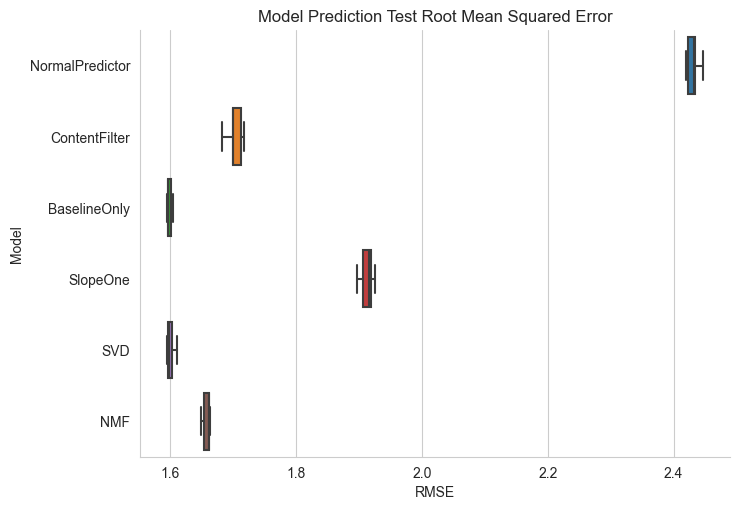

In [57]:
# Plot cross-validation RMSE results

# Convert results dict to dataframe
table = [['Model','RMSE','Fit_Time','Test_Time']]

for model, result in results.items():    
    rows = []
    header = True
    for metric, values in result.items():
        if header:
            row = []
            for i in range(len(values)):
                row.append(model)
            rows.append(row)
            header = False
        row = []
        for value in values:
            row.append(value)
        rows.append(row)
    rows = np.array(rows).T
    for row in rows:
        table.append(row.tolist())

results_df = pd.DataFrame(table[1:], columns = table[0])
results_df = results_df.astype({'Model': 'string', 
                                'RMSE': float, 
                                'Fit_Time': float, 
                                'Test_Time': float}, copy = False)

# RMSE box plot
sns.catplot(data = results_df, 
            y = 'Model', 
            x = 'RMSE', 
            kind = 'box', 
            aspect = 1.5)
plt.title('Model Prediction Test Root Mean Squared Error');

The above box plots of the models' RMSE on the prediction test shows that the normal predictor model performs worse than the other models, as anticipated.

The following chart depicts the top five models for a clearer view. The interquartile range of the SVD and baseline estimate models overlap, which indicates that there is likely no significant difference in the accuracy of these two models. There is no such overlap for the other models, suggesting that there is probably a significant difference in their prediction accuracy.

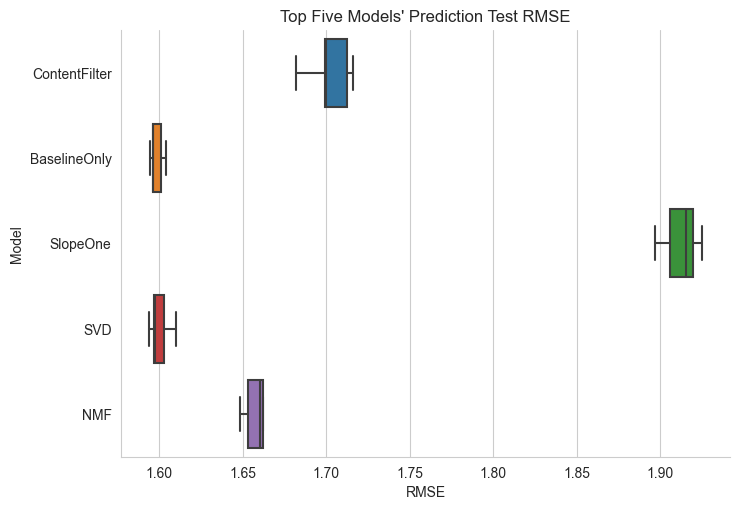

In [58]:
# Plot RMSE of all but normal predictor model
sns.catplot(data = results_df[results_df.Model != 'NormalPredictor'], 
            y = 'Model', 
            x = 'RMSE', 
            kind = 'box', 
            aspect = 1.5)
plt.title("Top Five Models' Prediction Test RMSE");

Box plots of the models' prediction test times are shown below. The interquartile range of the baseline estimate and SVD models are extremely narrow, but both also have one much slower outlier. The baseline estimate and SVD models' interquartile ranges fall completely within the range of the normal predictor model's interquartile range, which indicates that there might not be any significant difference. The slope one model is slower by roughly a factor of ten, and the content-based filter model is more than 25 times slower in predicting ratings.

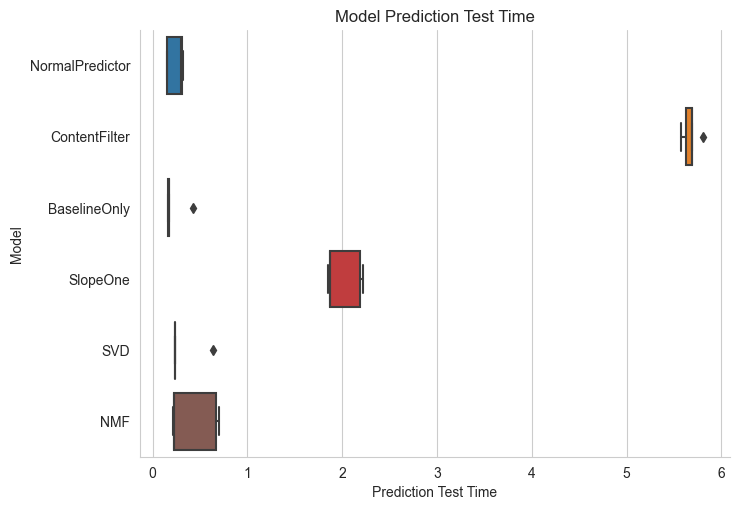

In [59]:
# Plot model prediction test time
g = sns.catplot(data = results_df, 
                y = 'Model', 
                x = 'Test_Time', 
                kind = 'box', 
                aspect = 1.5)
g.set_axis_labels('Prediction Test Time', 'Model')
plt.title('Model Prediction Test Time');

For a closer view, box plots of the five models with the fastest prediction times are shown below. The prediction times of the normal, baseline, SVD, and NMF models appear to be quite similar.

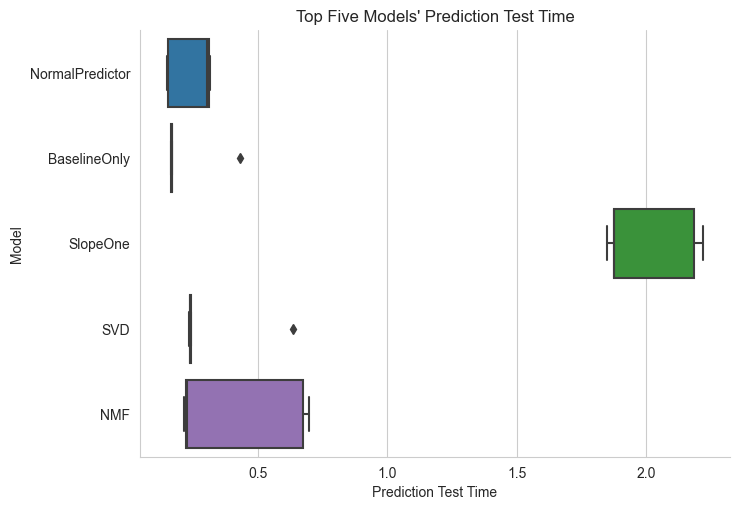

In [60]:
# Plot model prediction test time excluding content filter
g = sns.catplot(data = results_df[results_df.Model != 'ContentFilter'], 
                y = 'Model', 
                x = 'Test_Time', 
                kind = 'box', 
                aspect = 1.5)
g.set_axis_labels('Prediction Test Time', 'Model')
plt.title("Top Five Models' Prediction Test Time");

The following box plots depict the model fitting time results. The normal predictor is significantly faster than the others. This is to be expected because the algorithm does nothing more than calculate the mean and standard deviation to train the model for determining the normal distribution from which to randomly select predictions. The slope one model is roughly four times slower than the NMF model.

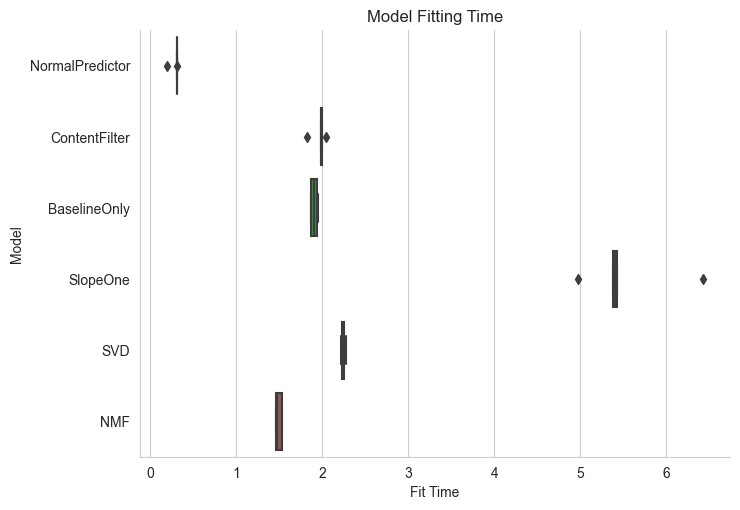

In [61]:
# Box plots of fit time
g = sns.catplot(data = results_df, y = 'Model', x = 'Fit_Time', kind = 'box', aspect = 1.5)
g.set_axis_labels('Fit Time', 'Model')
plt.title('Model Fitting Time');

The five models with the fastest training time are shown below. None of the interquartile ranges overlap, suggesting that these times are likely signicantly different. The SVD model's 30 epochs of stochastic gradient descent (SGD) contribute to it being the slower than the NMF's 10 epochs. Interestingly, the baseline estimate model also uses 30 epochs of SGD, but is still faster than the SVD model.

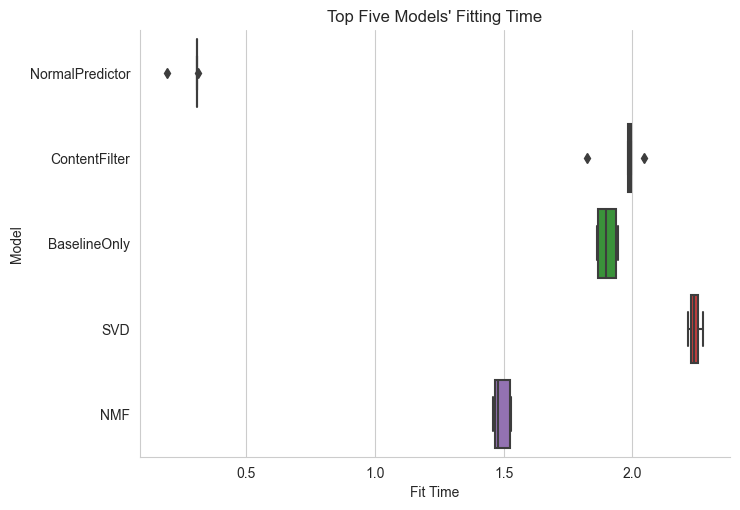

In [62]:
# Box plots of fit time excluding slope one
g = sns.catplot(data = results_df[results_df.Model != 'SlopeOne'], 
                y = 'Model', 
                x = 'Fit_Time', 
                kind = 'box', 
                aspect = 1.5)
g.set_axis_labels('Fit Time', 'Model')
plt.title("Top Five Models' Fitting Time");

# Discussion
The 5-fold cross-validation test results indicate that the baseline estimate and SVD models both achieve the most accurate predictions. However, the baseline estimate model is faster to train and slightly faster in making predictions on this data set. Taken together with the fact that matrix factorization models cannot easily incorporate new data, the baseline estimate model might be the better choice for this data, but this would likely depend on the context in which it is implemented.

Unsurprisingly, the randomly selecting ratings from a normal distribution resulted in low accuracy. Setting this obvious low bar aside, the slope one model was also surprisingly poor at predicting user ratings. Even though it is a model-based collaborative filtering model, it turned out to require so much memory that it crashed the kernel several times. It also was the slowest to train and slower than all but the content-based filter when making predictions.

The content-based filter model made more accurate predictions than slope one, but it was the slowest at doing so. However, there might be ways to optimize the prediction algorithm for speed, which were not explored here. It is perhaps surprising that it was able to perform as well as it did in terms of accuracy based on only the similarity of keywords in titles and authors' surnames. Additional information, such as book genre, or synopses might make it possible to improve this, but it would also slow the training time.

It is worth noting that these results were obtained on a single machine for a particular set of data. The algorithms could perform differently on other datasets and in different implementations, such as with distributed computing. Also, I have focused here on prediction accuracy for all ratings; however, for most real-world recommender systems, it is the highest ratings which are of particular importance because we generally wish to predict which items a user will rate the highest. Therefore, future research should focus on how these algorithms perform in terms of precision on the top ratings in the data. Another area worth exploring is how the models perform in terms of prediction diversity. Depending on the context, it might be desireable to introduce users to new items which the user might like but which are different in some way from previously chosen items.

# References

Carifio, J., & Perla, R. J. (2007). Ten common misunderstandings, misconceptions, persistent myths and urban legends about Likert scales and Likert response formats and their antidotes. _Journal of Social Sciences, 3_(3), 106–116. [https://thescipub.com/pdf/jssp.2007.106.116.pdf](https://thescipub.com/pdf/jssp.2007.106.116.pdf)

Hug, N. (2020). Surprise: A Python library for recommender systems. _Journal of Open Source Software, 5_(52), 2174. [https://doi.org/10.21105/joss.02174](https://doi.org/10.21105/joss.02174)

Koren, Y. (2010). Factor in the neighbors: Scalable and accurate collaborative filtering. _ACM Transactions on Knowledge Discovery from Data, 4_(1), 1–24. [https://doi.org/10.1145/1644873.1644874](https://doi.org/10.1145/1644873.1644874)

Koren, Y., Bell, R., & Volinsky, C. (2009). Matrix factorization techniques for recommender systems. _IEEE Computer, 42_(8), 30–37.
[https://doi.org/10.1109/MC.2009.263](https://doi.org/10.1109/MC.2009.263)

Lemire, D., & Maclachlan, A. (2005). Slope one predictors for online rating-based collaborative filtering. In _Proceedings of the 2005 SIAM International Conference on Data Mining_ (pp. 471–475). [https://doi.org/10.48550/arXiv.cs/0702144](
https://doi.org/10.48550/arXiv.cs/0702144)

Leskovec, J., Rajaraman, A., & Ullman, J. (2020). _Mining of massive datasets._ Cambridge University Press. [http://www.mmds.org/](http://www.mmds.org/)

Möbius. (2022). Book recommendation dataset. Kaggle. [https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset)

Ordorica, D. (2022, February 25). Using NLP to create a recommender system. _All Data Science._ [https://www.alldatascience.com/nlp/using-nlp-to-create-a-recommender-system/](https://www.alldatascience.com/nlp/using-nlp-to-create-a-recommender-system/)

Sauro, J. (2011). Should you care if your rating scale data is interval or ordinal? _Measuring U._ [https://measuringu.com/interval-ordinal/](https://measuringu.com/interval-ordinal/)

Zand Scholten, A., Borsboom, D. (2009). A reanalysis of Lord’s statistical treatment of football numbers.
_Journal of Mathematical Psychology, 53_(2), 69–75. [https://doi.org/10.1016/j.jmp.2009.01.002](https://doi.org/10.1016/j.jmp.2009.01.002)

Zhang, S., Wang, W., Ford, J., & Makedon, F. (2006). Learning from incomplete ratings using non-negative matrix factorization. In _Proceedings of the 2006 SIAM International Conference on Data Mining_ (pp. 549–553). [https://doi.org/10.1137/1.9781611972764.58](https://doi.org/10.1137/1.9781611972764.58)

Ziegler, C-N., McNee, S. M., Konstan, J. A., & Lausen, G. (2005). 
Improving recommendation lists through topic diversification. _WWW '05: Proceedings of the 14th international conference on World Wide Web_ (pp. 22–32). [https://doi.org/10.1145/1060745.1060754](https://doi.org/10.1145/1060745.1060754)